In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DIP

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1c69eUIfPfi6r3aS038Of4RbJLYg2M7W7/DIP


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os

In [3]:
# !pip install roboflow

In [4]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="uhrpY7vYVAtQ6Of79idJ")
# project = rf.workspace("mrkbil-projects").project("cloth-defect-detection")
# version = project.version(3)
# dataset = version.download("multiclass")

# train_path='/content/Cloth-Defect-Detection-3/train'
# valid_path='/content/Cloth-Defect-Detection-3/valid'
# test_path='/content/Cloth-Defect-Detection-3/test'
# classes='/_classes.csv'

In [5]:
train_path='Dataset/Cloth Defect Detection.v3i.multiclass/train'
valid_path='Dataset/Cloth Defect Detection.v3i.multiclass/valid'
test_path='Dataset/Cloth Defect Detection.v3i.multiclass/test'
classes='/_classes.csv'

In [6]:
train_df=pd.read_csv(train_path+classes)
test_df=pd.read_csv(test_path+classes)
valid_df=pd.read_csv(valid_path+classes)

In [7]:
train_df.columns=['filename', 'Broken-Button', 'Button', 'Color', 'Hole', 'Swing','yarn']
test_df.columns=['filename', 'Broken-Button', 'Button', 'Color', 'Hole', 'Swing','yarn']
valid_df.columns=['filename', 'Broken-Button', 'Button', 'Color', 'Hole', 'Swing','yarn']
train_df.head(2)

,filename,Broken-Button,Button,Color,Hole,Swing,yarn
0,IMG-20240501-WA0027_jpg.rf.d7b5983d6bfebedac99...,1,0,0,0,0,0
1,IMG-20240501-WA0051_jpg.rf.d83af70aa1df5010cf5...,1,0,0,0,0,0


In [8]:
from tqdm import tqdm

target_size=(640, 640)

def load_images_and_labels(df, directory):
    dataset = []
    total_samples = len(df)
    i=0
    for index, row in tqdm(df.iterrows(), total=total_samples, desc="Loading Images"):
        # if(i==10):
        #   break
        i+=1
        filename = row['filename']
        filepath = os.path.join(directory, filename)

        img = cv2.imread(filepath)
        img = cv2.resize(img, target_size)

        label = row[['Broken-Button', 'Button', 'Color', 'Hole', 'Swing', 'yarn']].values.tolist()

        dataset.append((img, label))
    return dataset

def get_x_y_from_dataset(dataset):
    X = np.array([data_point[0] for data_point in dataset])
    y = np.array([data_point[1] for data_point in dataset])
    return X, y

In [9]:
train_data=load_images_and_labels(train_df,train_path)
test_data=load_images_and_labels(test_df,test_path)
valid_data=load_images_and_labels(valid_df,valid_path)

Loading Images: 100%|██████████| 55/55 [00:15<00:00,  3.47it/s]


In [10]:
X_train, y_train = get_x_y_from_dataset(train_data)
X_test, y_test = get_x_y_from_dataset(test_data)
X_valid, y_valid = get_x_y_from_dataset(valid_data)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (564, 640, 640, 3)
Shape of y_train: (564, 6)
Shape of X_test: (26, 640, 640, 3)
Shape of y_test: (26, 6)
Shape of X_valid: (55, 640, 640, 3)
Shape of y_valid: (55, 6)


In [11]:
from sklearn.model_selection import train_test_split

merged_X = np.concatenate([X_train, X_test, X_valid], axis=0)
merged_y = np.concatenate([y_train, y_test, y_valid], axis=0)
print("Shape of merged_X:", merged_X.shape)
print("Shape of merged_y:", merged_y.shape)

X_train, X_test, y_train, y_test = train_test_split(merged_X, merged_y, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of merged_X: (645, 640, 640, 3)
Shape of merged_y: (645, 6)
Shape of X_train: (516, 640, 640, 3)
Shape of y_train: (516, 6)
Shape of X_test: (129, 640, 640, 3)
Shape of y_test: (129, 6)


Sample images from training set:


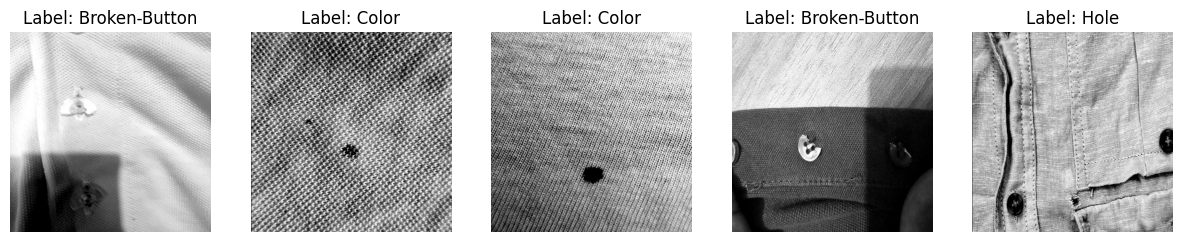

Sample images from testing set:


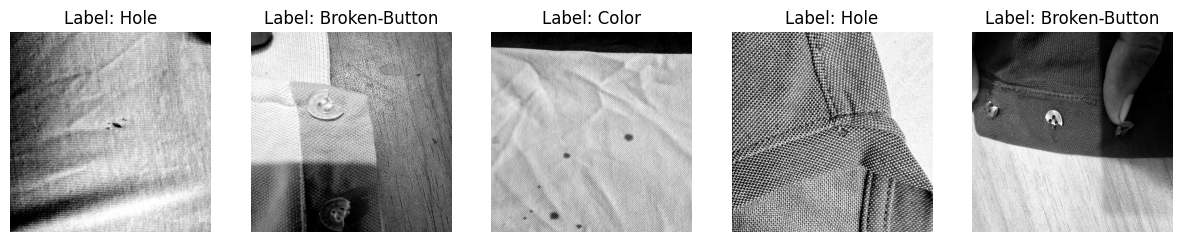

In [12]:
def show_samples(images, labels, label_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        axes[i].imshow(images[i])
        label_index = labels[i].argmax()
        label_name = label_names[label_index]
        axes[i].set_title("Label: {}".format(label_name))
        axes[i].axis('off')

    plt.show()

label_names = ['Broken-Button', 'Button', 'Color', 'Hole', 'Swing', 'yarn']

print("Sample images from training set:")
show_samples(X_train, y_train, label_names)

print("Sample images from testing set:")
show_samples(X_test, y_test, label_names)


# Creating Model

In [13]:
from tensorflow.keras.applications import InceptionResNetV2

inceptionresnet_v2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(640, 640, 3))

for layer in inceptionresnet_v2.layers:
  layer.trainable = False

219055592/219055592 [==============================] - 1s 0us/step


In [14]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(inceptionresnet_v2)
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(Dense(128, activation='sigmoid'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Flatten())
model.add(Dense(6,activation="softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 18, 18, 1536)      54336736  
 ional)                                                          
                                                                 
 dense (Dense)               (None, 18, 18, 256)       393472    
                                                                 
 dropout (Dropout)           (None, 18, 18, 256)       0         
                                                                 
 dense_1 (Dense)             (None, 18, 18, 128)       32896     
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 128)       0         
                                                                 
 dense_2 (Dense)             (None, 18, 18, 64)        8256      
                                                        

In [16]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'Bestmodels/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     mode='max',
                                     verbose=1)

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_callback])

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 2.2395 - accuracy: 0.2868
Epoch 1: val_accuracy improved from -inf to 0.04651, saving model to Bestmodels/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 94s 4s/step - loss: 2.2395 - accuracy: 0.2868 - val_loss: 1.8657 - val_accuracy: 0.0465
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.5881 - accuracy: 0.3023
Epoch 2: val_accuracy improved from 0.04651 to 0.42636, saving model to Bestmodels/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5
17/17 [==============================] - 39s 2s/step - loss: 1.5881 - accuracy: 0.3023 - val_loss: 1.7807 - val_accuracy: 0.4264
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.5319 - accuracy: 0.3702
Epoch 3: val_accuracy did not improve from 0.42636
17/17 [==============================] - 35s 2s/step - loss: 1.5319 - accuracy: 0.3702 - val_loss: 1.7779 - val_accuracy: 0.4264
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 1.5353 - accuracy: 0.3605
Epoch 4: val_accuracy did not improve from 0.42636
17/17 [==============================] - 35s 2s/step - loss: 1.5353 - a

In [19]:
# from keras.models import load_model
# model = load_model(checkpoint_filepath)

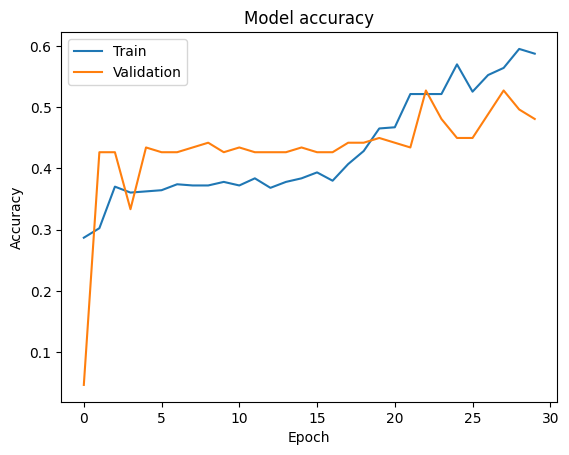

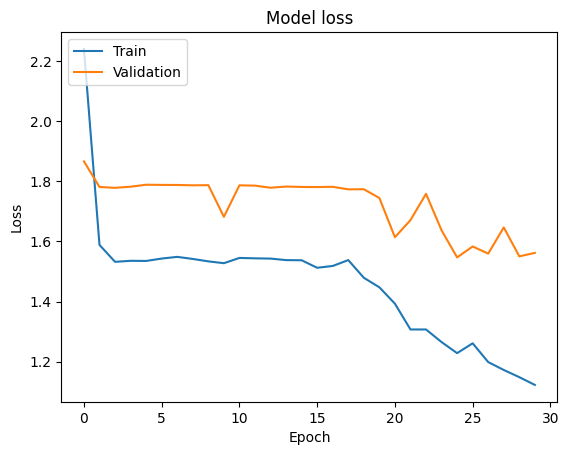

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [21]:
loss,accuracy = model.evaluate(X_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

5/5 [==============================] - 6s 1s/step - loss: 1.5616 - accuracy: 0.4806
loss: 1.5615696907043457
Accuracy: 0.4806201457977295


In [22]:
y_pred = model.predict(X_test)

5/5 [==============================] - 9s 1s/step


In [23]:
print(y_test.shape,y_pred.shape)

(129, 6) (129, 6)


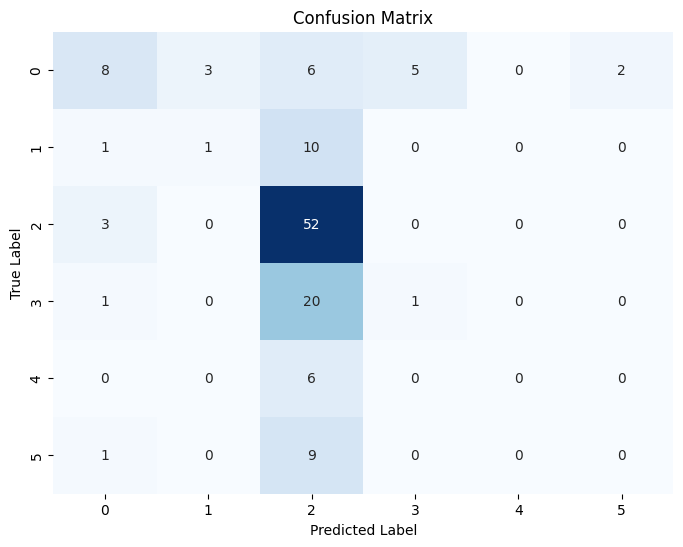

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [25]:
from sklearn.metrics import classification_report

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

report = classification_report(y_test_labels, y_pred_labels, output_dict=True)

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.33      0.42        24
           1       0.25      0.08      0.12        12
           2       0.50      0.95      0.66        55
           3       0.17      0.05      0.07        22
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        10

    accuracy                           0.48       129
   macro avg       0.25      0.23      0.21       129
weighted avg       0.37      0.48      0.38       129



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Sample images with predicted labels:


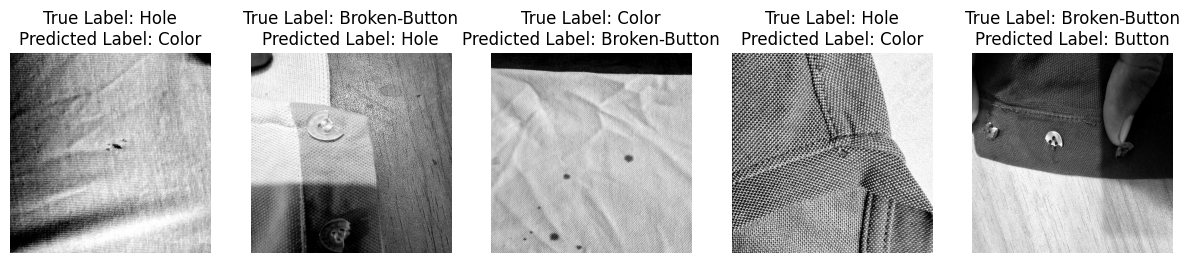

In [26]:
import matplotlib.pyplot as plt

def show_sample_images(images, labels, predicted_labels, label_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        axes[i].imshow(images[i])
        true_label = label_names[labels[i]]
        predicted_label = label_names[predicted_labels[i]]
        axes[i].set_title("True Label: {}\nPredicted Label: {}".format(true_label, predicted_label))
        axes[i].axis('off')

    plt.show()

print("Sample images with predicted labels:")
show_sample_images(X_test, y_test_labels, y_pred_labels, label_names)
